<a href="https://colab.research.google.com/github/clagonco/Big-Data/blob/main/proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalamos PySpark si no está instalado
!pip install pyspark

# Importamos las librerías necesarias
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
import urllib.request
import zipfile
import os

# Creamos una sesión de Spark
spark = SparkSession.builder.appName("OnlineRetail").getOrCreate()

# Definimos la URL de la base de datos y la ruta de descarga
dataset_url = "https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip"
zip_path = "/content/online_retail_ii.zip"
extract_path = "/content/online_retail_ii"

# Instalamos las librerías necesarias
!pip install pyspark pandas openpyxl

# Importamos las librerías
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
import urllib.request
import zipfile
import os

# Creamos una sesión de Spark
spark = SparkSession.builder.appName("OnlineRetail").getOrCreate()

# Definimos la URL y rutas de descarga
dataset_url = "https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip"
zip_path = "/content/online_retail_ii.zip"
extract_path = "/content/online_retail_ii"

# Descargamos el archivo ZIP
urllib.request.urlretrieve(dataset_url, zip_path)

# Extraemos el archivo ZIP
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# Verificamos qué archivos se extrajeron
files = os.listdir(extract_path)
print("Archivos extraídos:", files)

# Ruta del archivo Excel
excel_path = os.path.join(extract_path, "online_retail_II.xlsx")

# Cargamos el archivo Excel con Pandas
df_pandas = pd.read_excel(excel_path, sheet_name="Year 2009-2010")

# Guardamos el DataFrame de Pandas como CSV
csv_path = os.path.join(extract_path, "online_retail_II.csv")
df_pandas.to_csv(csv_path, index=False)

print(f"Archivo convertido a CSV: {csv_path}")

# Cargamos el CSV en un DataFrame de Spark
df_spark = spark.read.csv(csv_path, header=True, inferSchema=True)

# Mostramos las primeras filas para verificar la carga
df_spark.show(5)


Archivos extraídos: ['online_retail_II.xlsx']
Archivo convertido a CSV: /content/online_retail_ii/online_retail_II.csv
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|    13085.0|United Kingdom|
+-------+---------+--------------------+--------+--------

In [ ]:
# Mostrar el esquema del DataFrame
df_spark.printSchema()

# Contar valores nulos por columna
from pyspark.sql.functions import col, sum

null_counts = df_spark.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_spark.columns])
null_counts.show()

# Contar duplicados
print(f"Cantidad de registros duplicados: {df_spark.count() - df_spark.dropDuplicates().count()}")

# Descripción estadística de los datos
df_spark.describe().show()


root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)

+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|      0|        0|       2928|       0|          0|    0|     107927|      0|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+

Cantidad de registros duplicados: 6865
+-------+------------------+------------------+--------------------+------------------+------------------+------------------+-----------+
|summary|           Invoice|         StockCode|         Description|          Quantity|     

In [ ]:
# Eliminamos filas con valores nulos en columnas clave
df_clean = df_spark.dropna(subset=["Invoice", "StockCode", "Customer ID"])

# Filtramos valores negativos en Quantity y UnitPrice
df_clean = df_clean.filter((col("Quantity") > 0) & (col("Price") > 0))

# Mostrar los primeros registros limpios
df_clean.show(5)


+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|    22041|"RECORD FRAME 7""...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|    13085.0|United Kingdom|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import expr

# Crear una columna con el monto total (Cantidad * Precio Unitario)
df_clean = df_clean.withColumn("TotalAmount", expr("Quantity * Price"))

# Mostrar resultados
df_clean.select("Quantity", "Price", "TotalAmount").show(5)


+--------+-----+------------------+
|Quantity|Price|       TotalAmount|
+--------+-----+------------------+
|      12| 6.95|              83.4|
|      12| 6.75|              81.0|
|      12| 6.75|              81.0|
|      48|  2.1|100.80000000000001|
|      24| 1.25|              30.0|
+--------+-----+------------------+
only showing top 5 rows



In [ ]:
# Verificar Configuracion de la Arquitectura

# Confirmar la versión de Spark y Pandas
print(f"Versión de PySpark: {pyspark.__version__}")
print(f"Versión de Pandas: {pd.__version__}")

# Comprobar la conversión de DataFrame de Spark a Pandas
df_sample = df_clean.limit(5).toPandas()
print(df_sample)

# Ejecutar una operación básica con Spark
df_clean.agg({"TotalAmount": "sum"}).show()

Versión de PySpark: 3.5.5
Versión de Pandas: 2.2.2
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041      "RECORD FRAME 7"" SINGLE SIZE "        48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  TotalAmount  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom         83.4  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom         81.0  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom         81.0  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom        100.8  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom         30.0  
+-----------------+
| sum(TotalAmount)|
+-----------------+
|8832003.274003513|
+---------

In [ ]:
# Mas transformaciones

# Formatear Fechas
from pyspark.sql.functions import to_timestamp

df_clean = df_clean.withColumn("InvoiceDate", to_timestamp(col("InvoiceDate"), "yyyy-MM-dd HH:mm:ss"))
df_clean.select("InvoiceDate").show(5)

# Segmentar por Ano y Mes
from pyspark.sql.functions import year, month

df_clean = df_clean.withColumn("Year", year(col("InvoiceDate"))) \
                   .withColumn("Month", month(col("InvoiceDate")))

df_clean.select("InvoiceDate", "Year", "Month").show(5)

# Segmentar por Pais
df_clean.groupBy("Country") \
    .sum("TotalAmount") \
    .orderBy(col("sum(TotalAmount)").desc()) \
    .show(10)

# Productos Mas Vendidos
df_clean.groupBy("StockCode") \
    .sum("Quantity") \
    .orderBy(col("sum(Quantity)").desc()) \
    .show(10)


+-------------------+
|        InvoiceDate|
+-------------------+
|2009-12-01 07:45:00|
|2009-12-01 07:45:00|
|2009-12-01 07:45:00|
|2009-12-01 07:45:00|
|2009-12-01 07:45:00|
+-------------------+
only showing top 5 rows

+-------------------+----+-----+
|        InvoiceDate|Year|Month|
+-------------------+----+-----+
|2009-12-01 07:45:00|2009|   12|
|2009-12-01 07:45:00|2009|   12|
|2009-12-01 07:45:00|2009|   12|
|2009-12-01 07:45:00|2009|   12|
|2009-12-01 07:45:00|2009|   12|
+-------------------+----+-----+
only showing top 5 rows

+--------------+------------------+
|       Country|  sum(TotalAmount)|
+--------------+------------------+
|United Kingdom| 7414755.963002025|
|          EIRE|356085.21000000084|
|   Netherlands| 268785.9999999994|
|       Germany|202395.32099999953|
|        France|146215.41999999998|
|        Sweden| 53171.38999999995|
|       Denmark| 50906.85000000004|
|         Spain| 47601.42000000007|
|   Switzerland| 43921.39000000007|
|     Australia|31446.7

In [ ]:
# Clientes mas vendidos
df_clean.groupBy("Customer ID") \
    .sum("TotalAmount") \
    .orderBy(col("sum(TotalAmount)").desc()) \
    .show(10)

+-----------+------------------+
|Customer ID|  sum(TotalAmount)|
+-----------+------------------+
|    18102.0| 349164.3500000002|
|    14646.0|248396.49999999942|
|    14156.0|196566.73999999967|
|    14911.0|152147.56999999966|
|    13694.0|131443.19000000012|
|    17511.0| 84541.16999999995|
|    15061.0| 83284.37999999995|
|    16684.0| 80489.20999999999|
|    16754.0| 65500.07000000001|
|    17949.0| 60117.59999999999|
+-----------+------------------+
only showing top 10 rows



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuración de estilo para gráficos
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)


<ipython-input-19-41ce3f0c547d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_country["Country"][:10], y=df_country["sum(TotalAmount)"][:10], palette="viridis")


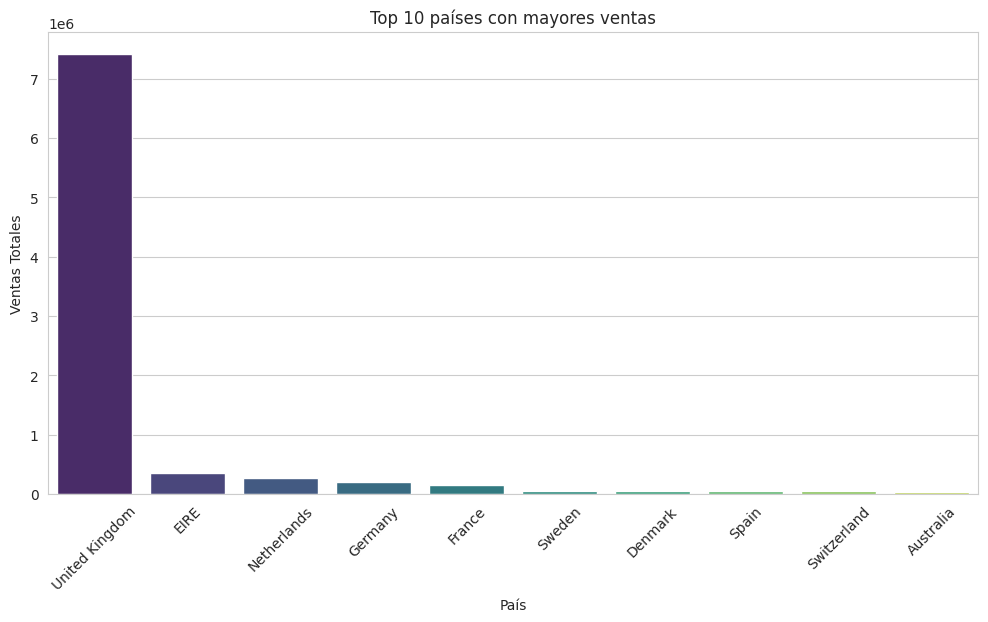

In [ ]:
# Convertimos el DataFrame de Spark a Pandas
df_country = df_clean.groupBy("Country") \
    .sum("TotalAmount") \
    .orderBy(col("sum(TotalAmount)").desc()) \
    .toPandas()

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=df_country["Country"][:10], y=df_country["sum(TotalAmount)"][:10], palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("País")
plt.ylabel("Ventas Totales")
plt.title("Top 10 países con mayores ventas")
plt.show()


<ipython-input-20-d487d216630c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_products["Description"][:10], y=df_products["sum(Quantity)"][:10], palette="coolwarm")


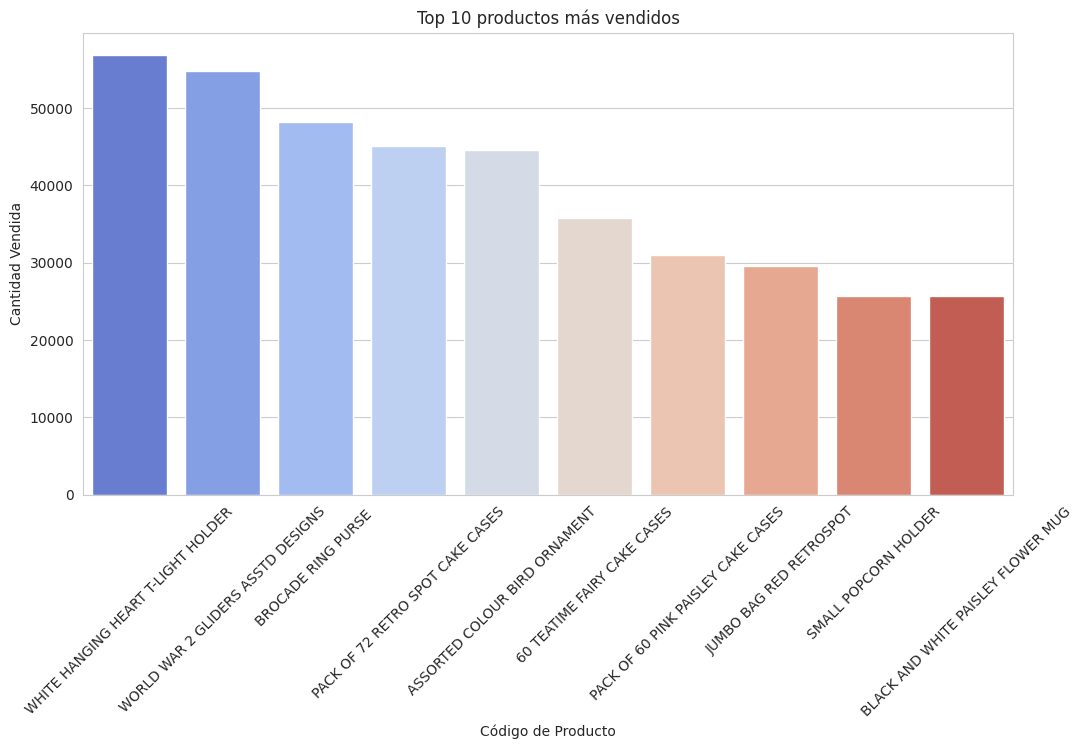

In [ ]:
# Convertimos el DataFrame de Spark a Pandas
df_products = df_clean.groupBy("Description") \
    .sum("Quantity") \
    .orderBy(col("sum(Quantity)").desc()) \
    .toPandas()

# Gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=df_products["Description"][:10], y=df_products["sum(Quantity)"][:10], palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Código de Producto")
plt.ylabel("Cantidad Vendida")
plt.title("Top 10 productos más vendidos")
plt.show()


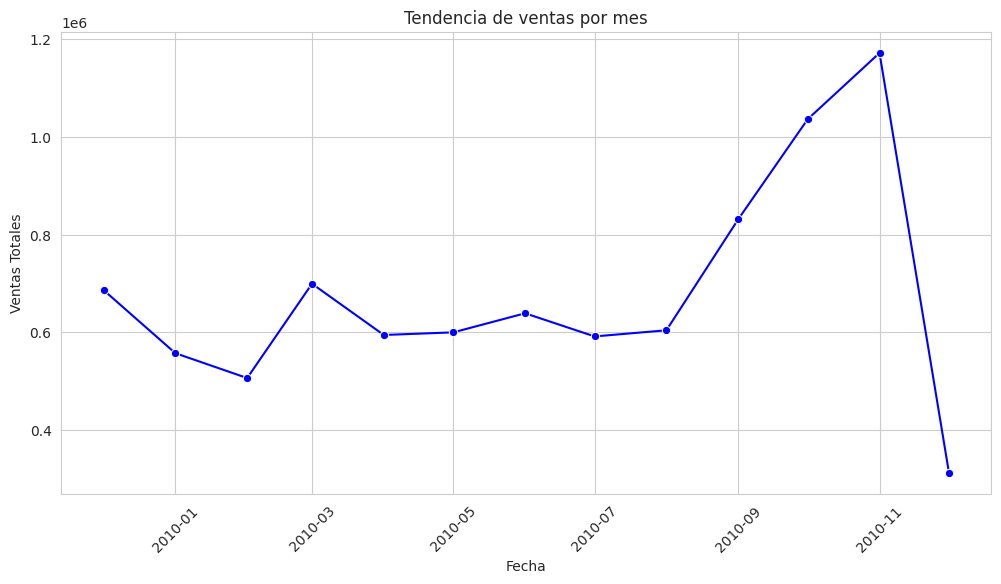

In [ ]:
# Convertimos el DataFrame de Spark a Pandas
df_monthly = df_clean.groupBy("Year", "Month") \
    .sum("TotalAmount") \
    .orderBy(["Year", "Month"]) \
    .toPandas()

# Crear columna de fecha
df_monthly["Date"] = pd.to_datetime(df_monthly["Year"].astype(str) + "-" + df_monthly["Month"].astype(str))

# Gráfico de línea
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_monthly["Date"], y=df_monthly["sum(TotalAmount)"], marker="o", color="blue")
plt.xlabel("Fecha")
plt.ylabel("Ventas Totales")
plt.title("Tendencia de ventas por mes")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Convertimos el DataFrame de Spark a Pandas
df_clients = df_clean.groupBy("Customer ID") \
    .sum("TotalAmount") \
    .orderBy(col("sum(TotalAmount)").desc()) \
    .toPandas()

# Mostrar los 10 clientes con más compras
df_clients.head(10)


,Customer ID,sum(TotalAmount)
0,18102.0,349164.35
1,14646.0,248396.50
2,14156.0,196566.74
3,14911.0,152147.57
4,13694.0,131443.19
5,17511.0,84541.17
6,15061.0,83284.38
7,16684.0,80489.21
8,16754.0,65500.07
9,17949.0,60117.60
